In [27]:
import fluxions as fl
import numpy as np
from numpy import isclose
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Implementation decisions

## Flexible Syntax

We aimed to support as much syntax as reasonably possible. Consider the function:

In [2]:
x = fl.Var('x')
y = fl.Var('y')

f = x * y

### Simple derivative using dictionary variable binding

In [3]:
f.diff({'x': 2, 'y': 3})

array([[3., 2.]])

### Passing an array to bind variables

In [4]:
f.diff(np.array([[1, 3], [2, 4]]))

array([[3., 1.],
       [4., 2.]])

### Fluxion objects are aware of their expected input

In [5]:
f.shape()

(2, 1)

### Binding a mixture of scalars and vectors

In [6]:
f.diff({'x': 3, 'y': np.array([1,2])})

array([[1., 3.],
       [2., 3.]])

### Default values for variables

In [7]:
x = fl.Var('x', 2)
y = fl.Var('y')

g = x + y

g.val({'y': 1})

array([[3.]])

### Pre-bind variables for immediate evaluation

Rather than instantiating fluxion variable objects, only to immediately evaluate them, you can just pass raw values straight into fluxion functions. The ouput is a FluxionResult object of the form 
```python
(val, diff)
```
In this case evaluation occurs at the same that time the computation graph is being built. The computation graph is not built and then evaluated

In [8]:
fl.sin(np.pi)

FluxionResult(1.2246467991473532e-16,-1.0)

### Mix pre-binding with input values

In [9]:
g = fl.sin(np.pi) * fl.Var('x')

In [10]:
g.diff(5)

array([[-5.]])

## Behind the scenes implementation - Numpy

Our computation graph is evaluated using a dict of variable bindings on the way down, and numpy arrays on the way up

In [11]:
x = fl.Var('x')
y = fl.Var('y')

f = x * y

### Binding vector variables

In [12]:
f.diff({'x': np.array([1, 2]), 'y': np.array([3,4])})

array([[3., 1.],
       [4., 2.]])

We note that each node in the the computation graph returns a tuple of its values and its derivative at that point.

For example in the code above, the intermediate function calls would return:

```python

# f = x * y

# Evaluating Var('x')
(array([[1.], [2.]]), array([[1., 0.], [1., 0.]]))

# Evaluating Var('y')
(array([[3.], [4.]]), array([[0., 1.], [0., 1.]]))

# Evaluating Mul(x, y)
(array([[3.], [8.]]), array([[3., 1.], [4., 2.]]))
```

# fl.jacobian
- Though implemented as a *function* rather than a *class*, `jacobian` was designed to maintain the Fluxion API

  1. To compute the Jacobian of `F` with respect to `v`, evaluated at value(s) given by `v_mapping`: 
   
   <pre>
   jacobian(F, v, v_mapping)
   </pre>
   
  2. `jacobian` will always return a numpy array

***

### Example 1: 
function from $\mathbb{R^1} \rightarrow \mathbb{R^1}$: same as derivative (and returns scalar)

$$
\begin{aligned}
F(y) &= ylog(y) \\ 
\Rightarrow J_F(y) &= log(y) + 1 \\
\Rightarrow J_F(1) &= 1
\end{aligned}
$$

In [13]:
y = fl.Var('y')
log_y = fl.log(y)
f = y*log_y

display(
    f.diff({'y':1})
)

# Jacobian of a scalar function from R^1 -> R^1
display(
    fl.jacobian(f, ['y'], {'y':1})
)

array([[1.]])

array(1.)

***

### Example 2: 
If F is a function from $\mathbb{R^m} \rightarrow \mathbb{R^n}$, then `jacobian` returns an m:n array if `v_mapping` contains scalar variable mappings

   
$$
\begin{aligned}
F(x,y) &= \begin{bmatrix} x^2 \\ x ln(y) \end{bmatrix} \\ \\
\Rightarrow J_F(x,y) &= \begin{bmatrix}
2x & x^2 \\
ln(y) & x/y
\end{bmatrix} \\ \\
\Rightarrow J_F(2,1) &= \begin{bmatrix}
4 & 0 \\ 
0 & 2
\end{bmatrix}
\end{aligned}
$$

In [14]:
x = fl.Var('x')

# Jacobian of a vector-valued function
fl.jacobian([x**2, x*log_y], ['x','y'], {'x':2, 'y':1})

array([[4., 0.],
       [0., 2.]])

***

### Example 3:
`jacobian` handles tensors: if variables `v` mapped to vectors of length T, then `jacobian` returns an **m : n : T** array

In [15]:
# Jacobian of a 3:2:10 function
J = fl.jacobian([x**2, x*log_y, x+y], ['x','y'], {'x':np.linspace(1,10,10), 'y':np.logspace(1,10,10)})
J.shape

(2, 3, 10)

---

## Behind the scenes:

- Blindly pass dict of variable bindings down the computation tree, and know an array of partials will be returned

In [16]:
z= fl.Var('z')

F = [x*y*z, y**2]
f1 = x*y*z
f2 = y**2

seed = {'x':1, 'y':1, 'z':1}
v_mapping = {'x':1, 'y':2, 'z':3}

display(
    f1.diff(v_mapping, seed)
)
display(
    f2.diff(v_mapping, seed)
)

array([[6., 3., 2.]])

array([[0., 4., 0.]])

# Optimization with Fluxions

### Test Function

We will use the Rosenbrock function as a test function for our optimization suite:

$f(x,y) = 100(y-x^2)^2 + (1-x)^2$

let's see if we can do our AM205 homework using fluxions:

http://iacs-courses.seas.harvard.edu/courses/am205/hw/am205_hw5.pdf

In [17]:
def f(x):
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2
def df(x):
    return np.array([-400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0]),200*(x[1]-x[0]**2)])
def ddf(x):
    return np.array([[400*(3*x[0]**2-x[1]) + 2,-400*x[0]],[-400*x[0],200]])

### Countour Plot

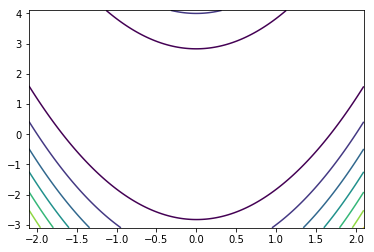

In [18]:
x = np.linspace(-2.1, 2.1, 1000)
y = np.linspace(-3.1, 4.1, 1000)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])
plt.contour(X, Y, Z)#, colors='black');
plt.show()

### The function is steep, with sharp countours

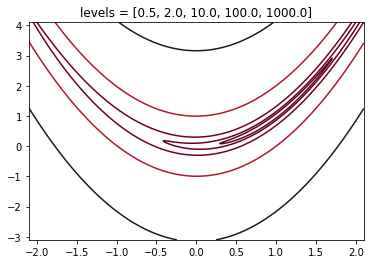

In [19]:
plt.figure()
levels = np.array([0.5,2,10,100,1000])
CS = plt.contour(X, Y, Z, levels=levels, cmap='RdGy')
plt.title('levels = {}'.format(levels.tolist()))
plt.show()

### Write the Rosenbrock function as a fluxion

In [20]:
x = fl.Var('x')
y = fl.Var('y')
F = 100*(y-x**2)**2 + (1-x)**2
dF = [-400*x*(y-x**2) - 2*(1-x),200*(y-x**2)] #we will use this later, for Newton's method

### Use the fluxion version of steepest descent with scipy.optimize.line_search and a limit of 2000 iterations

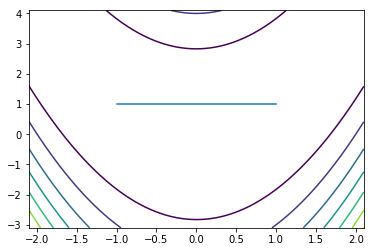

starting point = [-1, 1]
iterations = 2
stepsize = 0.0
minimum = [1. 1.]


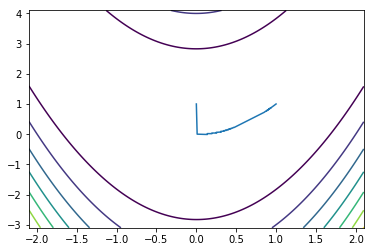

starting point = [0, 1]
iterations = 1571
stepsize = 9.782419804558578e-09
minimum = [0.99999956 0.99999914]


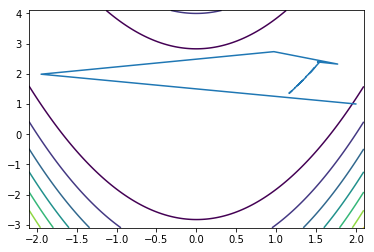

starting point = [2, 1]
iterations = 2000
stepsize = 0.00046291842657949665
minimum = [1.16610637 1.36025519]


In [21]:
points = [[-1, 1],[0, 1],[2, 1]]
for x in points:
    (xs,iterations,stepsize,minimum) = fl.steepest_descent(x,F)
    plt.plot(xs[:,0], xs[:,1])
    plt.contour(X, Y, Z)
    plt.show()
    print("starting point = " + str(x))
    print("iterations = " + str(iterations))
    print("stepsize = " + str(stepsize))
    print("minimum = " + str(minimum))

### Use the fluxion version of newton's method

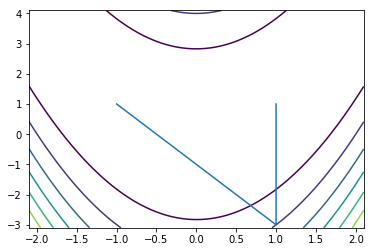

starting point = [-1, 1]
iterations = 2
stepsize = 1.7486981853308442e-13
minimum = [1. 1.]


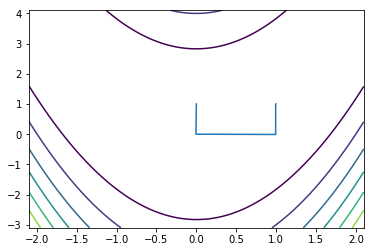

starting point = [0, 1]
iterations = 5
stepsize = 7.129738786932919e-12
minimum = [1. 1.]


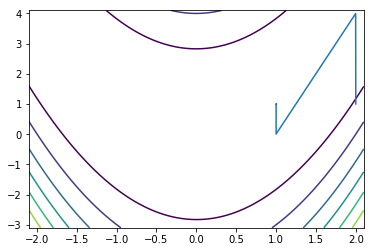

starting point = [2, 1]
iterations = 5
stepsize = 0.0
minimum = [1. 1.]


In [22]:
# points = [[-1, 1],[0, 1],[2, 1]]
for x in points:
    (xs,iterations,stepsize,minimum) = fl.newtons_method(np.array(x),F,dF)
    plt.plot(xs[:,0], xs[:,1])
    plt.contour(X, Y, Z)
    plt.xlim(-2.1, 2.1)
    plt.ylim(-3.1, 4.1)
    plt.show()
    print("starting point = " + str(x))
    print("iterations = " + str(iterations))
    print("stepsize = " + str(stepsize))
    print("minimum = " + str(minimum))

### Use the fluxion version of bfgs

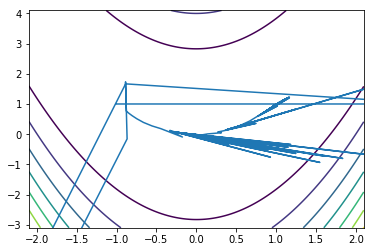

starting point = [-1, 1]
iterations = 124
stepsize = 3.34585762725827e-10
minimum = [1. 1.]


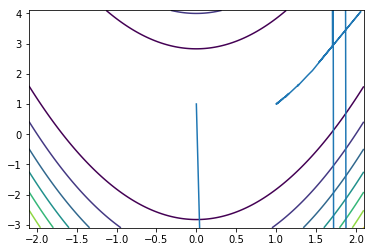

starting point = [0, 1]
iterations = 38
stepsize = 4.7152892656251685e-12
minimum = [1. 1.]


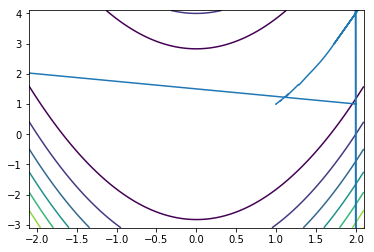

starting point = [2, 1]
iterations = 45
stepsize = 1.1140764244124239e-11
minimum = [1. 1.]


In [23]:
# points = [[-1, 1],[0, 1],[2, 1]]
for x in points:
    (xs,iterations,stepsize,minimum) = fl.bfgs(x,F)
    plt.plot(xs[:,0], xs[:,1])
    plt.contour(X, Y, Z)
    plt.xlim(-2.1, 2.1)
    plt.ylim(-3.1, 4.1)
    plt.show()
    print("starting point = " + str(x))
    print("iterations = " + str(iterations))
    print("stepsize = " + str(stepsize))
    print("minimum = " + str(minimum))

# Simulating Planetary Orbits with a Symplectic Integrator

The name of this library in Fluxions in homage to Isaac Newton, whose early name for differential calculus was "the method of fluxions."  (For an entertaining work of  fiction that places the invention of calculus in historical context, I highly recommend Neal Stephenson's Baroque Cycle.)  The problem Newton was trying to solve was calculating the motion of the planets around the sun under the influence of gravity.  He succeeded in calculating a highly accuracte approximation based on all the planets moving around the sun in elliptical orbits.  This approximation effectively treats the sun as a very heavy stationary body and all the planets orbit around it.  It ignores the gravitational forces between planets and any movement of the sun itself.  It's a good approximation because the sun is much heavier than the planets put toghether (approximately 99.8% of the of the mass of the solar system), but it's not perfect because Jupiter in particular is heavy enough to throw things off.

**Kepler's Laws for Elliptical Orbits**
<img src="../graphics/kepler.gif">

Citation: http://hyperphysics.phy-astr.gsu.edu/hbase/kepler.html

## Numerical Solution of Differential Equations with Symplectic Integrators
How do scientists and engineers today compute planetary orbits to the highest standards of precision suitable for launching space vehicles?  They use numerical integrators to solve the Newton's equations of motion.  In particular, they use a special class of numerical integrators called **symplectic integrators**.  Most students in STEM fields who encounter differential equations are likely to see an unrepresentative sample of ones that are analytically tractable, such as a simple harmonic oscillator.  It turns out that most differential equations of interest do **not** have analytical solutions, but have to be solved numerically instead.  This is a mature field of study in applied mathematics, and many methods exist.

A simple numerical method is the highly intuitive Forward Euler Method, in which the equation is discretized in time:
<img src="../graphics/forward_euler_method.png">

Citation: https://en.wikipedia.org/wiki/Euler_method#/media/File:Euler_method.svg

As the picture suggests, discretization errors can gradually accumulate and the approximated trajectory can drift away from the true solution.  These errors can be mitigated by using higher order methods with small step size, but unless an integrator is carefully constructed, it is likely to have a drift where it either gains or loses energy as the system evolves.  This destroys its ability to make accurate calculations over a large number of steps.

### Hamilton's Equations
No discussion of symplectic integrators would be complete without introducing Hamilton's equations.  This is a formalism for solving the equations of motion in a physical system.  The spatial coordinates are $q = (q_1, ... q_n)$ and their "conjugate momenta" are $p = (p_1, ... p_n)$.  

$$\frac{d\mathcal{p}_i}{dt} = -\frac{\partial \mathcal{H}}{\partial q_i} \\
\frac{dq_i}{dt} = +\frac{\partial \mathcal{H}}{\partial p_i}$$

The highly symmetrical dual structure of these equations give Hamiltonian systems their special properties.
This can look like a bit much at first, but there's a physical intuition that helps to understand it:
* $q_i$ are the x, y, and z coordinates of different bodies in the problem
* $p_i$ are the x, y, and z coordinates of the momentum of the bodies; $p_i = m_i v_i$

For a classical mechanical system,
$$\mathcal{H} = T + U$$
where $T$ is the total kinetic energy of the system, and $U$ is the total potential energy of the system.
A very important special case is easier to solve: when the Hamiltonian is *separable* and *time invariant*.  
In this case, the kinetic energy $T = T(p)$ depends only on the momenta $p$, 
and the potential energy $U = U(q)$ depends only on the position.

It can be proven mathematically that any Hamiltonian system (i.e. a system that evolves according to these differential equations) has two special properties:
* It conserves volume in phase space, $dV = dp \; dq$
* It conserves energy $\mathcal{H}(p, q) = \mathcal{H}_0$



### Bad Idea: Simulating a Hamiltonian System with a Non-Symplectic Integrator
What happens if you try to simulate a Hamiltonian system with a non-symplectic integrator? It loses its special properties.  The simulated solution will not conserve energy and volume in phase space.

<img src="../graphics/non_symplectic_ham_steps.png">

Citation: https://www.av8n.com/physics/symplectic-integrator.htm

### What is a Symplectic Integrator?
The figure above shows a typical behavior of a non-symplectic integrator that is gradually leaking energy.  If this were a planetary orbit, the simulation would show the planet crashing into the sun at a time when it should still enjoy a stable orbit.

A symplectic integrator on the other hand **respects** the two key symmetries of the Hamiltonian system.
* It conserves energy
* It conserves volume

### Conservation of Energy

<img src="../graphics/symplectic_ham_steps.png">

Citation: https://www.av8n.com/physics/symplectic-integrator.htm

### Convervation of Volume in Phase Space

Here are visualizations of the fact that symplectic integrators conserve volume in phase space, but non-symplectic integrators do not:
<img src="../graphics/non_symplectic_ham_volume.png">
<img src="../graphics/symplectic_ham_volume.png">

Citation: https://www.av8n.com/physics/symplectic-integrator.htm

One way to think of a symplectic integrator is that it models the behavior of another symplectic system (one that conserves energy and volume in phase space) that is very close to the true system.  
Whereas a non-symplectic integrator models a system close to the true system, but one that is not symplectic.

### Better Idea: Leapfrog Integration -- A Simple Symplectic Integrator
Fortunately there is a simple scheme for numerically solving separable Hamiltonian systems that is symplectic.  It is called Leapfrog Integration.  Here is a presentation in "traditional" coordinates $x$, $v$ and $a$ for position, velocity, and acceleration respectively.  Please note that velocities are indexed at half-integer time steps.
\begin{align}
x_i &= v_{i-1} + v_{i-1/2} \Delta t \\
a_i &= F(x_i) / m_i \\
v_{i+1/2} &= v_{i-1/2} + a_i \Delta t
\end{align}

Here is an equivalent version with only integer indices that is better suited to direct translation into computer code.
This version of the equations was used in the planetary simulation we wrote.
\begin{align}
x_{i+1} &= x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2
\end{align}

citation: https://en.wikipedia.org/wiki/Leapfrog_integration

This embarrassingly simple code is at the heart of the planetary simulation presented below:
```python
# Perform leapfrog integration simulation
# https://en.wikipedia.org/wiki/Leapfrog_integration
print(f'Performing leapfrog integration with {N} steps...')
for i in tqdm(range(N-1)):
    # Positions at the next time step
    q[i+1,:] = q[i,:] + v[i,:] * dt + 0.5 * a[i,:] * dt2
    # Accelerations of each body in the system at the next time step
    a[i+1,:] = accel_func(q[i+1])        
    # Velocities of each body at the next time step
    v[i+1,:] = v[i,:] + 0.5 * (a[i,:] + a[i+1,:]) * dt
    return q, v
```

## Modern Calculations of Planetary Orbits and Ephemerides

Planetary orbits can be described accurately with just a small number of parameters called **orbital elements**.  These quantities date back to Johannes Kepler and are sometimes referred to as Keplerian elements in his honor.  The reason an entire orbit can be decribed locally with just six parameters is that the orbits are very close to following elliptical paths as discovered by Kepler.  Here is a picture illustrating the definitions of the orbital elements.

<img src="../graphics/orbital_elements.png">

Citation: By Lasunncty at the English Wikipedia, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8971052

Professionals working in astronomy and space exploration have collaborated over the years and built an excellent infrastructure for efficiently sharing data about the positions and orientations of celestial bodies.  Important ideas that feed into this include standardization of time measurements and reference frames.

### Julian Days and Astronomical Time Measurements
Astronomy is one of the oldest sciences and historical records date back millennia.  Astronomers have defined the concept of the Julian Day (https://en.wikipedia.org/wiki/Julian_day) as the number of days from the beginning of the Julian Period.  The Julian period began on January 1, 4713 BC on the proleptic Julian Calendar.  It's straightforward to find a conversion utility.  If you write your own be sure to check it against a reference implementation on the web!

### Ecliptic Coordinate Systems and Astronomical Frames of Reference
We take it for granted that we can describe the location of an object on the earth to a high degree of precision with just two numbers, latitude and longitude.  Pinning down the position of an object in the solar system is much more complicated because everything is always moving around.  The barycenter of the solar system (center of mass) makes a convenient origin, but you also need to define axes.  Astronomers have done this by standardizing on the ideas of an ecliptic coordinate system:

<img src="../graphics/heliocentric_rectangular_ecliptic.png">

Citation: By Tfr000 (talk) 18:12, 20 June 2012 (UTC) - Own work, CC BY-SA 3.0, 
https://commons.wikimedia.org/w/index.php?curid=19971787

The most common frame in use today is called **J2000.0 epoch** and is based on the coordinate system above with the mean equinox of the year 2000.

### Ephemerides and jplephem library
An ephemeris in astronomy (plural ephemerides) comes from the Greek word for "diaries."  It refers to the positions of astronomical orbits at a moment in time.  Before the advent of computers, they were generated by a combination of astronomical observations and hand calculations.  In modern times, computer simulations can produce very accurate ephemerides for important objects like the planets in the solar system.  NASA and the JPL (Jet Propulsion Laboratory) at Caltech run a public service where they offer high quality ephemerides free to the public.  This is offered through an interface called Horizons which can be found here: https://ssd.jpl.nasa.gov/horizons.cgi
Fortunately there is a package available on PyPI called **jplephem** available here: https://pypi.org/project/jplephem/.
This is a very cool package that lets you get to work doing astronomical calculations in minutes.  
The most convenient way to use it is to download a data file once and save it locally.  I downloaded the de430.bsp file here: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/
This file is 117 MB but includes positions of the planets between the years 1550 and 2650.  I excerpted it down to 40 years to reduce the size fo 4.26 MB so it would fit on GitHub.

Here is a quick showing how easy it is to use (citation: jplephem documentation on PyPI)

In [24]:
from jplephem.spk import SPK
kernel = SPK.open('../solar_system/resources/planets.bsp')
print(kernel)

File type DAF/SPK and format LTL-IEEE with 14 segments:
2451544.50..2466160.50  Solar System Barycenter (0) -> Mercury Barycenter (1)
2451536.50..2466160.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2451536.50..2466160.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2451536.50..2466160.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2451536.50..2466160.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2451536.50..2466160.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2451536.50..2466160.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2451536.50..2466160.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2451536.50..2466160.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2451536.50..2466160.50  Solar System Barycenter (0) -> Sun (10)
2451544.50..2466156.50  Earth Barycenter (3) -> Moon (301)
2451544.50..2466156.50  Earth Barycenter (3) -> Earth (399)
2287184.50..2688976.50  Mercury Barycenter (1) -> Mercury (199)
228718

The documentation tells us that all coordinates are in the J2000.0 coordinate system.  Distances are given in kilometers.  The positions of the sun and 9 planets including Pluto are given vs. the barycenter of the solar system.  Here's how to get the position of the earth on February 8, 2015, which is Julian day 2457061.5:

In [25]:
position = kernel[0,3].compute(2457061.5)
print(position)

[-1.10369890e+08  8.93069592e+07  3.86931886e+07]


The system includes the ability to compute the velocity by differentiating a Chebyshev polynomial, as follows:

In [26]:
position, velocity = kernel[0,3].compute_and_differentiate(2457061.5)
print(velocity)

[-1740702.19738961 -1781622.22600993  -772367.63928313]


## Putting it Together: Strategy to Simulate the Solar System
Interested readers can of course review the code.  The highlights are:
* Install the jplephem package
* Download the de430.bsp data file with ephemerides from the JPL
* Write function to load the physical constants used: gravitational constant G, and masses of the sun and planets in kg (these are all available on Wikipedia)
* Write a utility function julian_day that converts a Python date to a julian day
* Write a function configuration(t0, t1, steps_per_day) that returns an array with time steps indexing the rows and positions and velocities across the columns.  For the sun and 8 planets, there are 27 positions and 27 velocities: sun_x, sun_y, sun_z, mercury ..., venus ..., earth, ... ... neptune.
* Write a function accel(q) that compute the acceleration applied to all 27 spatial coordinates (note this is time invariant).  This is for the "constructive" solution that doesn't use automatic differention, just Newton's equations directly
* Write a function make_force(q) that computes the forces applied to all the objects using the Fluxions library.  This is done by building a single Fluxion for the graviational potential energy U(q) once, and then differentiating it with respect to q.
* Write a function simulate_leapfrog() that takes among its arguments functions configuration_func and accel_func.  This allows the same integration back end to be used for both the constructive and Fluxions approach to the problem.
* Write a function energy(q, v) that computes the total energy in the system to check that it really conserves energy
* Write a function mse that computes the mean squared error between a simulated path and a reference path pulled directly from the JPL data
* Write functions to plot a still image and generate a movie clip of the orbit

That's it! The whole calculation is done in 271 lines of code in solar_sytem.py and 466 lines of code in eight_planets.py.  Much of that is constants, comments, testing, and making the movie.

Due to bugs with the bash magic command on Windows 10, it's best to demo running the program directly from the console.
<img src="../graphics/eight_planets_console_run.png">

We can see that this program works! It simulated the sun and 8 planets at 16 time steps per day for all of 2018 in just 3 seconds.  It has a mean squared error vs. the JPL simulation of 9.7E-5 astronomical units.  (That's actually very close on this scale; they're simulating other bodies e.g. the moon and the planets move around a lot.)  The energy checks out.  This system has an energy change on the order of 8.9e-10.  The JPL system shows a larger change on the order of 6.9E-7 because they are accounting for additional objects.  The orbits look essentially the same from the two sources.

<img src="../solar_system/figs/earth_sun_leapfrog.png">
<img src="../solar_system/figs/earth_sun_jpl.png">

<img src="../solar_system/figs/eight_planets_leapfrog.png">

In [31]:
import io
import base64

video = io.open('../solar_system/movie/planets.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

The soundtrack to this movie is from "The Planets" by Gustav Holst.  This is the opening of the piece, "Jupiter: The Bringer of Jollity"